In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# https://github.com/NREL/FieldCampaign
from FieldCampaign import database as fdb

# Compare north and south sodars
_Eliot Quon (eliot.quon@nrel.gov)_

Findings (based on analysis of 3 months of data):
- The offset between the south sodar and other instruments--by virtue of the _corrected_ north sodar signal--is approximately **-2$^\circ$**.
- This depends on the wind-direction offset (calculated by `sodar_lidar_met_correlation.ipynb`), which has inherent uncertainty; therefore, it is unclear whether a bias truly exists or not.

In [2]:
startdate = pd.to_datetime('2019-11-01')
enddate = pd.to_datetime('2020-01-31')

In [3]:
# consider northerly wind sector w/o terrain or turbine wake influence 
#comparison_dir_range = [300,359.9999]
#comparison_dir_range = [314,344] # sector from north sodar to T5
comparison_dir_range = [320,335]

In [4]:
# from `sodar_lidar_met_correlation.ipynb`
north_sodar_wdir_correction = -28.25901298

In [5]:
sodar_quality_cutoff = 90 # range: [0,100]

## get data from database

In [6]:
connect = fdb.Database()

INTIALIZE DATA BASE!!!
2019-11-15 00:00:00
2020-10-30 00:00:00
DATABASE INITIALIZED WITH START AND STOP TIME 2019-11-15 00:00:00 2020-10-30 00:00:00


In [7]:
%time df_hist = connect.get_data_from_db_1min(startdate,enddate)

# CPU times: user 40 s, sys: 13.8 s, total: 53.8 s
# Wall time: 2min 10s

CPU times: user 40.7 s, sys: 8.6 s, total: 49.3 s
Wall time: 1min 38s


In [8]:
df_hist['time'] = pd.to_datetime(df_hist['time'],format='%Y-%m-%d %H:%M:%S')
df_hist = df_hist.set_index('time')

In [9]:
north_wspd_cols = [col for col in df_hist.columns if col.startswith('sodar_') and col.endswith('_wind_speed') and not col.startswith('sodar_south')]
north_wdir_cols = [col for col in df_hist.columns if col.startswith('sodar_') and col.endswith('_wind_direction') and not col.startswith('sodar_south')]
north_qc_cols = [col for col in df_hist.columns if col.startswith('sodar_') and col.endswith('_quality') and not col.startswith('sodar_south')]

south_wspd_cols = [col for col in df_hist.columns if col.startswith('sodar_south_') and col.endswith('_wind_speed')]
south_wdir_cols = [col for col in df_hist.columns if col.startswith('sodar_south_') and col.endswith('_wind_direction')]
south_qc_cols = [col for col in df_hist.columns if col.startswith('sodar_south_') and col.endswith('_quality')]

## standardize data and put into dataframes

In [10]:
sodar = {}

In [11]:
%%time
df = pd.DataFrame()
for wscol,wdcol,qccol in zip(north_wspd_cols,north_wdir_cols,north_qc_cols):
    print(wscol,wdcol,qccol)
    hgt = wscol.split('_')[1][:-1]
    assert hgt == wdcol.split('_')[1][:-1]
    assert hgt == qccol.split('_')[1][:-1]
    tmp = pd.DataFrame()
    tmp['wspd'] = df_hist[wscol]
    # ************* CORRECT THE VELOCITY HERE!!! *************
    tmp['wdir'] = df_hist[wdcol] + north_sodar_wdir_correction
    tmp.loc[tmp['wdir'] < 0, 'wdir'] += 360
    tmp.loc[tmp['wdir'] >= 360, 'wdir'] -= 360
    tmp['qc'] = df_hist[qccol]
    tmp['height'] = float(hgt)
    df = pd.concat([df,tmp])
df = df.set_index('height',append=True).sort_index()
df = df.unstack().resample('10min').first().stack(dropna=False)
sodar['north'] = df

sodar_30m_wind_speed sodar_30m_wind_direction sodar_30m_quality
sodar_40m_wind_speed sodar_40m_wind_direction sodar_40m_quality
sodar_50m_wind_speed sodar_50m_wind_direction sodar_50m_quality
sodar_60m_wind_speed sodar_60m_wind_direction sodar_60m_quality
sodar_80m_wind_speed sodar_80m_wind_direction sodar_80m_quality
sodar_100m_wind_speed sodar_100m_wind_direction sodar_100m_quality
sodar_120m_wind_speed sodar_120m_wind_direction sodar_120m_quality
sodar_140m_wind_speed sodar_140m_wind_direction sodar_140m_quality
sodar_160m_wind_speed sodar_160m_wind_direction sodar_160m_quality
sodar_180m_wind_speed sodar_180m_wind_direction sodar_180m_quality
sodar_200m_wind_speed sodar_200m_wind_direction sodar_200m_quality
CPU times: user 5.76 s, sys: 427 ms, total: 6.19 s
Wall time: 6.22 s


In [12]:
%%time
df = pd.DataFrame()
for wscol,wdcol,qccol in zip(south_wspd_cols,south_wdir_cols,south_qc_cols):
    print(wscol,wdcol,qccol)
    hgt = wscol.split('_')[2][:-1]
    assert hgt == wdcol.split('_')[2][:-1]
    assert hgt == qccol.split('_')[2][:-1]
    tmp = pd.DataFrame()
    tmp['wspd'] = df_hist[wscol]
    tmp['wdir'] = df_hist[wdcol]
    tmp['qc'] = df_hist[qccol]
    tmp['height'] = float(hgt)
    df = pd.concat([df,tmp])
df = df.set_index('height',append=True).sort_index()
df = df.unstack().resample('10min').first().stack(dropna=False)
sodar['south'] = df

sodar_south_30m_wind_speed sodar_south_30m_wind_direction sodar_south_30m_quality
sodar_south_40m_wind_speed sodar_south_40m_wind_direction sodar_south_40m_quality
sodar_south_50m_wind_speed sodar_south_50m_wind_direction sodar_south_50m_quality
sodar_south_60m_wind_speed sodar_south_60m_wind_direction sodar_south_60m_quality
sodar_south_80m_wind_speed sodar_south_80m_wind_direction sodar_south_80m_quality
sodar_south_100m_wind_speed sodar_south_100m_wind_direction sodar_south_100m_quality
sodar_south_120m_wind_speed sodar_south_120m_wind_direction sodar_south_120m_quality
sodar_south_140m_wind_speed sodar_south_140m_wind_direction sodar_south_140m_quality
sodar_south_160m_wind_speed sodar_south_160m_wind_direction sodar_south_160m_quality
sodar_south_180m_wind_speed sodar_south_180m_wind_direction sodar_south_180m_quality
sodar_south_200m_wind_speed sodar_south_200m_wind_direction sodar_south_200m_quality
CPU times: user 5.69 s, sys: 388 ms, total: 6.08 s
Wall time: 6.09 s


In [13]:
alltimes = sodar['north'].index.levels[0]

## filter by wdir, quality

In [14]:
# select times with desired wind directions based on corrected north sodar wdir
wdir_selected = (sodar['north']['wdir'] >= comparison_dir_range[0]) & (sodar['north']['wdir'] <= comparison_dir_range[1])

In [15]:
for site,df in sodar.items():
    wdir = df['wdir']
    df = df.copy()
    df = df.loc[wdir_selected]
    df.loc[df['wdir']<100,'wdir'] += 360
    df.loc[(df['qc'] < sodar_quality_cutoff), :] = np.nan
    df = df.unstack().reindex(alltimes).stack(dropna=False)
    sodar[site] = df

In [16]:
bins_N = np.arange(*comparison_dir_range,2.5)
mean_wdir_S = np.mean(sodar['south']['wdir'])
bins_S = np.arange(mean_wdir_S-15, mean_wdir_S+15, 2.5)

Text(0.5, 1.0, 'south')

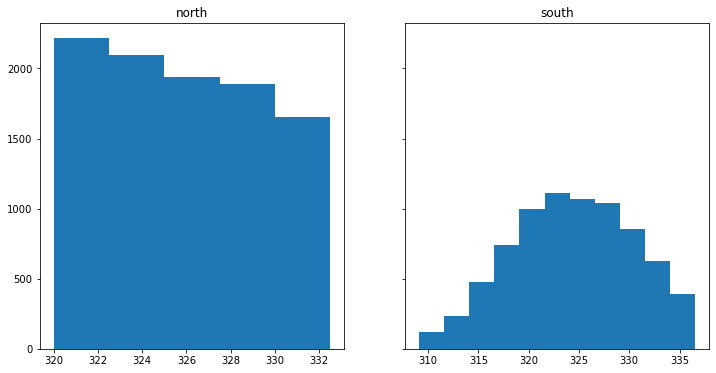

In [17]:
fig,ax = plt.subplots(ncols=2,sharey=True,figsize=(12,6))
#bins = np.arange(0,361,15)
#ax[0].hist(sodar['north']['wdir'],bins=bins)
#ax[1].hist(sodar['south']['wdir'],bins=bins)
ax[0].hist(sodar['north']['wdir'], bins=bins_N)
ax[1].hist(sodar['south']['wdir'], bins=bins_S)
ax[0].set_title('north')
ax[1].set_title('south')
#ax[0].set_xticks(np.arange(bins[0],bins[-1]+1,45))

## make scatter plots

In [18]:
def scat(ax,qty,z):
    # collect data
    x = sodar['south'].xs(z,level='height')[qty]
    y = sodar['north'].xs(z,level='height')[qty]
    # scatterplot w/ ref line
    ax.scatter(x,y,alpha=0.1)
    xlim = ax.get_xlim()
    ax.plot(xlim,xlim,color=[0,1,0],lw=1)
    ax.set_xlim(xlim)
    ax.set_xlabel('south sodar',fontsize='x-large')
    #ax.set_ylabel('north sodar',fontsize='x-large')
    ax.set_title(f'z = {z:g} m',fontsize='x-large')
    ax.grid()
    ax.axis('scaled')

In [19]:
comparison_heights = [40,80,120]
Nheights = len(comparison_heights)

### wind speed

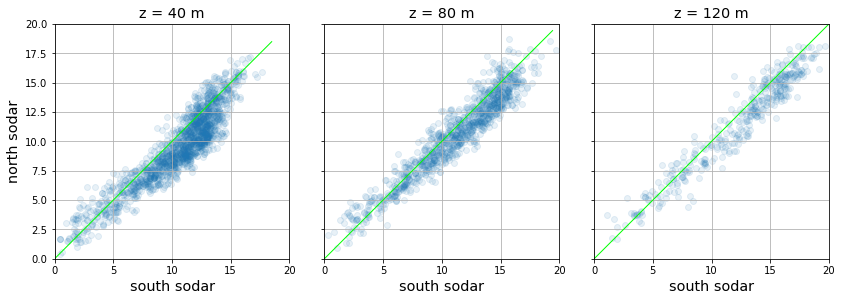

In [20]:
fig,ax = plt.subplots(ncols=Nheights,sharex=True,sharey=True,figsize=(Nheights*4,4))
for axi,hgt in zip(ax,comparison_heights):
    scat(axi,'wspd',hgt)
ax[0].set_ylabel('north sodar',fontsize='x-large')
ax[0].set_xlim((0,20))
ax[1].set_ylim((0,20))
fig.tight_layout()

### wind direction

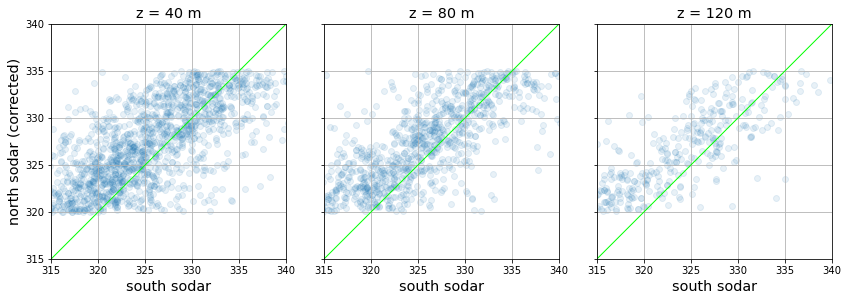

In [31]:
fig,ax = plt.subplots(ncols=Nheights,sharex=True,sharey=True,figsize=(Nheights*4,4))
for axi,hgt in zip(ax,comparison_heights):
    scat(axi,'wdir',hgt)
ax[0].set_ylabel('north sodar (corrected)',fontsize='x-large')
ax[0].set_xlim((315,340))
ax[1].set_ylim((315,340))
fig.tight_layout()

### estimate wind direction offset

In [22]:
def calc_fit_R2(x,y,slope=None):
    notna = ~(pd.isna(x) | pd.isna(y))
    x = x.loc[notna]
    y = y.loc[notna]
    if slope is None:
        coef = np.polyfit(x,y,1)
    else:
        offset = np.sum(y - slope*x) / len(x)
        coef = [slope,offset]
    p = np.poly1d(coef)
    f = p(x)
    ybar = np.mean(y)
    SSreg = np.sum((f - ybar)**2)
    SStot = np.sum((y - ybar)**2)
    R2 = SSreg / SStot
    return coef, R2

In [23]:
# linear fit, all data
z1 = 40.0
x = sodar['south'].xs(z1, level='height')['wdir']
y = sodar['north'].xs(z1, level='height')['wdir']
p,R2 = calc_fit_R2(x,y)
wdir_offset = p[1]
print('linear coeffs:',p,' R2=',R2)

linear coeffs: [1.42683030e-01 2.80673866e+02]  R2= 0.14314693537643605


In [24]:
# sanity check
calc_fit_R2(x,y,slope=p[0])

([0.1426830301740083, 280.67386645824166], 0.14314693537643605)

In [33]:
# linear fit, no outliers
z1 = 40.0
x = sodar['south'].xs(z1, level='height')['wdir']
y = sodar['north'].xs(z1, level='height')['wdir']
#p,R2 = calc_fit_R2(x,y,slope=1)
selected = (x > 310) & (x < 345)
p,R2 = calc_fit_R2(x[selected], y[selected])
wdir_offset = p[1]
print('linear coeffs:',p,' R2=',R2)

linear coeffs: [  0.44006158 183.96414018]  R2= 0.4399931910373086


In [36]:
# force slope==1, no outliers
z1 = 40.0
x = sodar['south'].xs(z1, level='height')['wdir']
y = sodar['north'].xs(z1, level='height')['wdir']
#p,R2 = calc_fit_R2(x,y,slope=1)
selected = (x > 310) & (x < 345)
p,R2 = calc_fit_R2(x[selected], y[selected], slope=1)
wdir_offset = p[1]
print('linear coeffs:',p,' R2=',R2)

linear coeffs: [1, 1.7657379449434754]  R2= 2.27205603773399


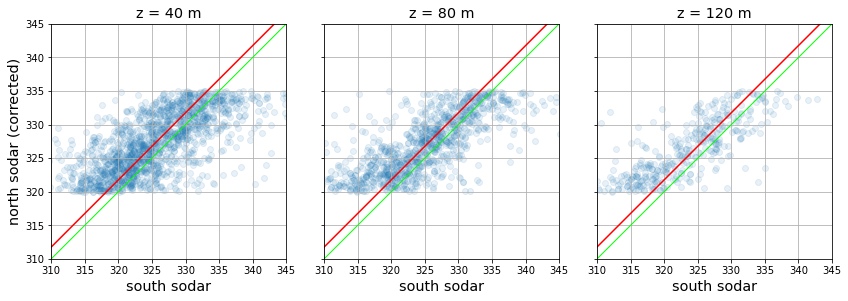

In [37]:
fig,ax = plt.subplots(ncols=Nheights,sharex=True,sharey=True,figsize=(Nheights*4,4))
for axi,hgt in zip(ax,comparison_heights):
    scat(axi,'wdir',hgt)
    xlim = axi.get_xlim()
    #axi.plot(xlim, [xlim[0]+wdir_offset, xlim[1]+wdir_offset], 'r')
    axi.plot(xlim, np.polyval(p, xlim), 'r')
ax[0].set_ylabel('north sodar (corrected)',fontsize='x-large')
ax[0].set_xlim((310,345))
ax[1].set_ylim((310,345))
# ax[0].set_xlim((290,360))
# ax[1].set_ylim((295,365))
fig.tight_layout()